# Data Analytics Group Project - Predicting Happiness Score

In this notebook we try to train a model that will attempt to correctly predict Happinesss Score. We have a target feature (Happiness Score) and a whole range of descripitve features, some which came with the Happiness Score data file, others we had to collect ourselves from a variety of different places such as the WHO. 



In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.formula.api as sm
from sklearn import metrics
import seaborn as sns

# Plots appear in notebook
%matplotlib inline

#Turn on automcompletion
%config IPCompleter.greedy=True

## Part 1: Combining Data from different Data Sets
### Part A - Load main dataframe

The main bulk of the data stems directly from the world happiness report website at http://worldhappiness.report/". There we obtained a file containing the happiness scores from 2008-2017. It actually goes back to 2006 for some countries, however we decided to just focus on the last 10 years. In addition it contains a couple of other features which we thought are very well suited as descriptive features. Some, where we were not quite sure on their meaning and quality we decided to drop and others were simply not of interest. 

For more detailed information on each descriptive feature, there is a pdf in the docs folder from the world happiness report,  which outlines exactly how these features were obtained. 

In [2]:
# Load in the csv from the happiness report website
main_df = pd.read_csv("raw_data/happiness&descriptivefeat_2008-2017.csv")
main_df.head()

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-15","gini of household income reported in Gallup, by wp5-year"
0,Afghanistan,2008,3.723590,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906
2,Afghanistan,2010,4.758381,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318
3,Afghanistan,2011,3.831719,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764
4,Afghanistan,2012,3.782938,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540


In [3]:
# Rename target feature "life ladder" to "happiness Score"
main_df = main_df.rename(columns={'Life Ladder': 'Happiness Score'})

In [4]:
# Change Happiness Score into categorical feature (0-10)
main_df["Happiness Score"] = round(main_df["Happiness Score"])

In [5]:
# Drop unwanted columns and unnecessary columns
main_df.drop(['Standard deviation of ladder by country-year', 'Standard deviation/Mean of ladder by country-year', 'GINI index (World Bank estimate)', 'GINI index (World Bank estimate), average 2000-15', 'gini of household income reported in Gallup, by wp5-year'], axis=1, inplace=True )
main_df.head()

,country,year,Happiness Score,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Afghanistan,2008,4.0,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084
1,Afghanistan,2009,4.0,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025
2,Afghanistan,2010,5.0,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176
3,Afghanistan,2011,4.0,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221
4,Afghanistan,2012,4.0,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078


### Part B - Add GDP (replacing log GDP)
There were a number of other datasets which we thought were interesting and maybe relevant in predicting happiness. One of them was crime rate. Unfortunately, the dataset only ranged back to 2012, and covered a different amount of countries in each year, and never the full amount of our main dataset which covers 162 countries starting from 2008-2017. So we decided to not add crime rate as it would simply add too much missing data

However, we did add some other features. One of them was raw GDP, which we used to replace the "Log GDP per capita". 

In [6]:
# read in GDP data
raw_gdp_df = pd.read_csv("raw_data/GDP2008_to_2017.csv")
raw_gdp_df.head()

,Country,Units,Scale,Country/Series-specific Notes,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Estimates Start After
0,Afghanistan,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",10.297,12.066,15.325,17.89,20.293,20.17,20.616,20.079,19.454,20.889,2016.0
1,Albania,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",12.901,12.093,11.938,12.896,12.323,12.784,13.246,11.338,11.865,13.181,2016.0
2,Algeria,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",171.001,137.054,161.207,200.251,209.016,209.755,213.81,165.874,159.049,178.287,2016.0
3,Angola,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",84.178,75.492,82.526,104.116,113.923,124.913,126.73,102.621,95.337,124.209,2015.0
4,Antigua and Barbuda,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1.368,1.224,1.152,1.142,1.211,1.193,1.28,1.365,1.46,1.524,2016.0


In [7]:
# drop unnecessary columns
raw_gdp_df.drop(["Units", "Scale", "Country/Series-specific Notes", "Estimates Start After"], axis=1, inplace=True)
raw_gdp_df.head()

,Country,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,10.297,12.066,15.325,17.89,20.293,20.17,20.616,20.079,19.454,20.889
1,Albania,12.901,12.093,11.938,12.896,12.323,12.784,13.246,11.338,11.865,13.181
2,Algeria,171.001,137.054,161.207,200.251,209.016,209.755,213.81,165.874,159.049,178.287
3,Angola,84.178,75.492,82.526,104.116,113.923,124.913,126.73,102.621,95.337,124.209
4,Antigua and Barbuda,1.368,1.224,1.152,1.142,1.211,1.193,1.28,1.365,1.46,1.524


In [8]:
# Check for duplicated rows
print("Number of duplicated rows: {}".format(sum(raw_gdp_df.duplicated())))

Number of duplicated rows: 0


In [9]:
# Convert raw_gdp_df into one more suitable for merging
raw_gdp_df = raw_gdp_df.rename(columns={"Country": "country"})
raw_gdp_df = pd.melt(raw_gdp_df, id_vars=["country"], var_name="year", value_name="GDP").sort_values(["country", "year"])
raw_gdp_df.head()

,country,year,GDP
0,Afghanistan,2008,10.297
195,Afghanistan,2009,12.066
390,Afghanistan,2010,15.325
585,Afghanistan,2011,17.89
780,Afghanistan,2012,20.293


In [10]:
# convert dataype of Year to int64
raw_gdp_df.year = raw_gdp_df.year.astype("int64", inplace=True)

In [11]:
# merge with the main df based on year and country
main_df = pd.merge(main_df, raw_gdp_df,  how='left', left_on=['country', "year"], right_on = ['country', "year"])
main_df.drop(["Log GDP per capita"], axis=1, inplace=True)
main_df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293


### Part C - Add life expectancy from WHO
Next we added additional life expectancy data from WHO besides the already existing "Healthy life expectancy at birth" feature

In [12]:
# read in WHO data
who_df = pd.read_csv("raw_data/WHOLifeExpectancy.csv")

# select desired columns
who_df = who_df[["Unnamed: 0", "Unnamed: 1", "Life expectancy at birth (years)", "Life expectancy at age 60 (years)"]]

# rename columns
who_df = who_df.rename(columns={"Unnamed: 0": "country", "Unnamed: 1": "year", "Life expectancy at birth (years)": "Life expectancy birth", "Life expectancy at age 60 (years)": "Life expectancy age 60"})

# drop first row (contains useless data)
who_df.drop(who_df.index[0], inplace=True)

# change dtypes
who_df.year = who_df.year.astype("int64", inplace=True)
who_df["Life expectancy birth"] = who_df["Life expectancy birth"].astype(float, inplace=True)
who_df["Life expectancy age 60"] = who_df["Life expectancy age 60"].astype(float, inplace=True)

who_df.head()

,country,year,Life expectancy birth,Life expectancy age 60
1,Afghanistan,2015,60.5,16.0
2,Afghanistan,2014,59.9,15.9
3,Afghanistan,2013,59.9,15.9
4,Afghanistan,2012,59.5,15.8
5,Afghanistan,2011,59.2,15.8


In [13]:
# merge with the main df based on year and country
main_df = pd.merge(main_df, who_df,  how='left', left_on=['country', "year"], right_on = ['country', "year"])
main_df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8


### Part D - Add Infant Mortality Rate

In [14]:
# read in infant mortality data
im_df = pd.read_csv("raw_data/Dying_baby_data.csv")

# rename columns
im_df = im_df.rename(columns={"Country": "country", "Year": "year", "Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)": "Infant mortality rate", "Neonatal mortality rate (per 1000 live births)": "Neonatal mortality rate", "Under-five mortality rate (probability of dying by age 5 per 1000 live births)": "Under-five mortality rate"})

im_df.head()

,country,year,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate
0,Afghanistan,2016,53.2 [44.0-62.2],40.0 [31.6-48.9],70.4 [56.6-84.7]
1,Afghanistan,2015,54.9 [46.5-63.1],41.1 [33.4-49.2],73.2 [60.2-86.1]
2,Afghanistan,2014,56.8 [49.0-64.4],42.4 [35.2-49.9],76.1 [64.0-88.1]
3,Afghanistan,2013,58.8 [51.7-66.1],43.7 [37.1-50.6],79.3 [68.2-90.7]
4,Afghanistan,2012,61.0 [54.6-67.8],45.1 [39.0-51.4],82.8 [72.7-93.4]


In [15]:
# only keep number of deaths for mortality rate
im_df[['Infant mortality rate', 'Neonatal mortality rate', 'Under-five mortality rate']] = im_df[[
    'Infant mortality rate', 'Neonatal mortality rate', 'Under-five mortality rate']].apply(lambda row: row.str.replace("(\[.+\])", ''))
im_df.head()

,country,year,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate
0,Afghanistan,2016,53.2,40.0,70.4
1,Afghanistan,2015,54.9,41.1,73.2
2,Afghanistan,2014,56.8,42.4,76.1
3,Afghanistan,2013,58.8,43.7,79.3
4,Afghanistan,2012,61.0,45.1,82.8


In [16]:
# merge with the main df based on year and country
main_df = pd.merge(main_df, im_df,  how='left', left_on=['country', "year"], right_on = ['country', "year"])
main_df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7,65.7,48.0,90.2
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8,63.3,46.5,86.4
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8,61.0,45.1,82.8


### Part E - Add CPI (world corruption ranking)

In [17]:
# read in CPI mortality data
cpi_df = pd.read_csv("raw_data/transparency_international_CPI.csv")

# drop unwanted columns
cpi_df.drop(["ISO3"], axis=1, inplace=True)

# rename columns
cpi_df = cpi_df.rename(columns={"Country": "country", "CPI score 2017": "2017", "CPI score 2016": "2016", "CPI score 2015": "2015", "CPI score 2014": "2014", "CPI Score 2013": "2013", "CPI Score 2012": "2012"})

# convert into a format suitable for merging
cpi_df = pd.melt(cpi_df, id_vars=["country"], var_name="year", value_name="CPI").sort_values(["country", "year"])

# conver dataype of Year to int64
cpi_df.year = cpi_df.year.astype("int64", inplace=True)
cpi_df.head()                       

,country,year,CPI
1081,Afghanistan,2012,8.0
900,Afghanistan,2013,8.0
719,Afghanistan,2014,12.0
538,Afghanistan,2015,11.0
357,Afghanistan,2016,15.0


In [18]:
# merge with the main df based on year and country
main_df = pd.merge(main_df, cpi_df,  how='left', left_on=['country', "year"], right_on = ['country', "year"])
main_df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate,CPI
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2,NaN
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1,NaN
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7,65.7,48.0,90.2,NaN
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8,63.3,46.5,86.4,NaN
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8,61.0,45.1,82.8,8.0


### Part F - Write merged file to csv

In [19]:
main_df.to_csv("processed_data/merged_happiness_data.csv", index=False)

## Part 2: Data Quality Report
### Part A - Overview & Analysis

In [20]:
# load in the merged data
df = pd.read_csv("processed_data/merged_happiness_data.csv")
df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate,CPI
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2,NaN
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1,NaN
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7,65.7,48.0,90.2,NaN
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8,63.3,46.5,86.4,NaN
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8,61.0,45.1,82.8,8.0


#### Target Feature:
The target feature is of course Happiness Score which is the National average response to the question “Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”

#### Descriptive Features
The descriptive features are as follows:
1. **country** 
2. **year**
3. **Social support** - The national average of the binary responses (either 0 or 1) to the question “If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”
4. **Healthy life expectancy at birth** - Life expectancy spent in “Good Health”. So not just Life Expectancy. Naturally Smaller than LE. 
5. **Freedom to make life choices** - The national average of responses to the question “Are you satisfied or dissatisfied with your freedom to choose what you do with your life?”
6. **Generosity** - The residual of regressing national average of response to the question “Have you donated money to a charity in the past month?” on GDP per capita.
7. **Perceptions of corruption** - The measure is the national average of the survey responses to two questions: (I) “Is corruption widespread throughout the government or not” and (II) “Is corruption widespread within businesses or not?”
8. **Positive affect** - The average of three positive affect measures: happiness, laugh and enjoyment. These measures are computed from responses to question such as “Did you smile or laugh a lot yesterday?”.
9. **Negative affect** - Defined as the average of three negative affect measures. They are worry, sadness and anger, respectively. These measures are computed from responses to question such as “Did you feel sad a lot yesterday?”.
10. **Confidence in national government** - Answer to “Do you have confidence in each of the following, or not? How about the national government?”
11. **Democratic Quality & Delivery Quality**: both are based on Worldwide Governance Indicators (WGI) project. The original data has six dimensions: Voice and Accountability, Political Stability and Absence of Violence, GovernmentEffectiveness, Regulatory Quality, Rule of Law, Control of Corruption which are reduced to two here.
12. **GDP**
13. **Life expectancy birth**
14. **Life expectancy age 60**
15. **Infant mortality rate:** Deaths per 1000 births
16. **Neonatal mortality rate:** neonatal deaths per 1000 births
17. **Under-five mortality rate:** under five deaths per 1000 births
18. **CPI:** World Corruption ranking


In [21]:
# Check for duplicated rows
print("Number of duplicated rows: {}".format(sum(main_df.duplicated())))

Number of duplicated rows: 0


In [22]:
# Check dtypes
df.dtypes

country                               object
year                                   int64
Happiness Score                      float64
Social support                       float64
Healthy life expectancy at birth     float64
Freedom to make life choices         float64
Generosity                           float64
Perceptions of corruption            float64
Positive affect                      float64
Negative affect                      float64
Confidence in national government    float64
Democratic Quality                   float64
Delivery Quality                     float64
GDP                                   object
Life expectancy birth                float64
Life expectancy age 60               float64
Infant mortality rate                float64
Neonatal mortality rate              float64
Under-five mortality rate            float64
CPI                                  float64
dtype: object

In [23]:
# Convert country and Happiness Score to categorical
df["country"] = df["country"].astype("category")
df["Happiness Score"] = df["Happiness Score"].astype("category")
df["year"] = df["year"].astype(int)

In [24]:
# Check number of countries
print("Number of countries in dataset: {}".format(len(main_df.country.unique())))

Number of countries in dataset: 164


Text(0,0.5,'Number of Countries')

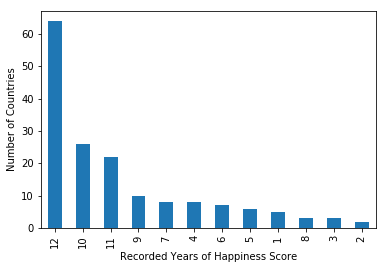

In [25]:
# Show for how many countries the happiness score is available in what time span
ax = df.country.value_counts().value_counts().plot(kind="bar")
ax.set_xlabel("Recorded Years of Happiness Score")
ax.set_ylabel("Number of Countries")

As we can see there are 64 countries for which we have a happiness score 12 years back. We are however only interested in the first 10 years, so we drop anything that is before 2008. Other countries have less data available but we thought this was no problem.

In [26]:
# drop years 2006 and 2007
df = df.drop(df[df.year < 2008].index)

Text(0,0.5,'Number of Countries')

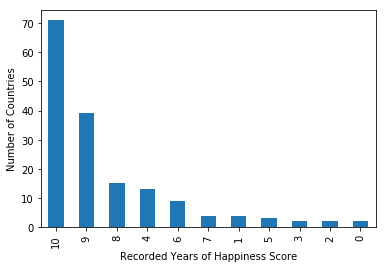

In [27]:
# Show for how many countries the happiness score is available in what time span
ax = df.country.value_counts().value_counts().plot(kind="bar")
ax.set_xlabel("Recorded Years of Happiness Score")
ax.set_ylabel("Number of Countries")

### Part B - Data Quality Report
#### Continous Data

In [28]:
#Get descriptive stats for continous data
con_feat = df.describe(exclude=["category"]).T

#Create a DF containing only continous data
con_df = df.select_dtypes(include=[np.number])
con_df.index = df.index

#Add Median
con_feat["median"] = con_df.median()

#Add Cardinality
con_feat["card"] = con_df.apply(pd.Series.nunique)

#Add percentage missing by checking for missing data in each column. 
#NOTE: This only considers NA values as missing. Data could still be absent
#      but replaced with a "dummy" entry such as a blank space or a zero.
#      This issue Will be adressed in the Data Quality plan.
con_feat["missPerc"] = con_df.isnull().apply(pd.Series.sum)/df.shape[0]

In [29]:
#Prettify the result, rearrange columns and get rid of the 50th percentile column (same as median).
con_feat = con_feat[["count", "missPerc", "card", "min", "25%", "mean", "median", "75%", "max", "std"]]
print("Descriptive statistics for continous features:\n")
#Rounding will not get saved. Is only done so that an overview of the df is easier to read.
display(con_feat.round(2))

Descriptive statistics for continous features:



,count,missPerc,card,min,25%,mean,median,75%,max,std
year,1344,0.00,10.0,2008,2010,2012.71,2013.00,2015,2017,2.80321
Social support,1333,0.01,1333.0,0.290184,0.744366,0.807455,0.83,0.903192,0.987343,0.120388
Healthy life expectancy at birth,1335,0.01,1283.0,39.352,57.2963,62.4791,64.04,68.2577,76.5364,7.81795
Freedom to make life choices,1321,0.02,1320.0,0.257534,0.632843,0.730154,0.75,0.846185,0.985178,0.145203
Generosity,1298,0.03,1298.0,-0.322952,-0.116502,-0.0012857,-0.02,0.0903371,0.677773,0.163636
Perceptions of corruption,1266,0.06,1266.0,0.035198,0.693012,0.751253,0.81,0.87893,0.983276,0.186422
Positive affect,1328,0.01,1328.0,0.362498,0.61851,0.707503,0.72,0.799503,0.943621,0.108929
Negative affect,1334,0.01,1334.0,0.0834258,0.20339,0.264871,0.25,0.314821,0.70459,0.0861513
Confidence in national government,1191,0.11,1191.0,0.0840612,0.330437,0.479033,0.46,0.609824,0.993604,0.190713
Democratic Quality,1176,0.12,1176.0,-2.44823,-0.786532,-0.14099,-0.24,0.645864,1.5401,0.882947


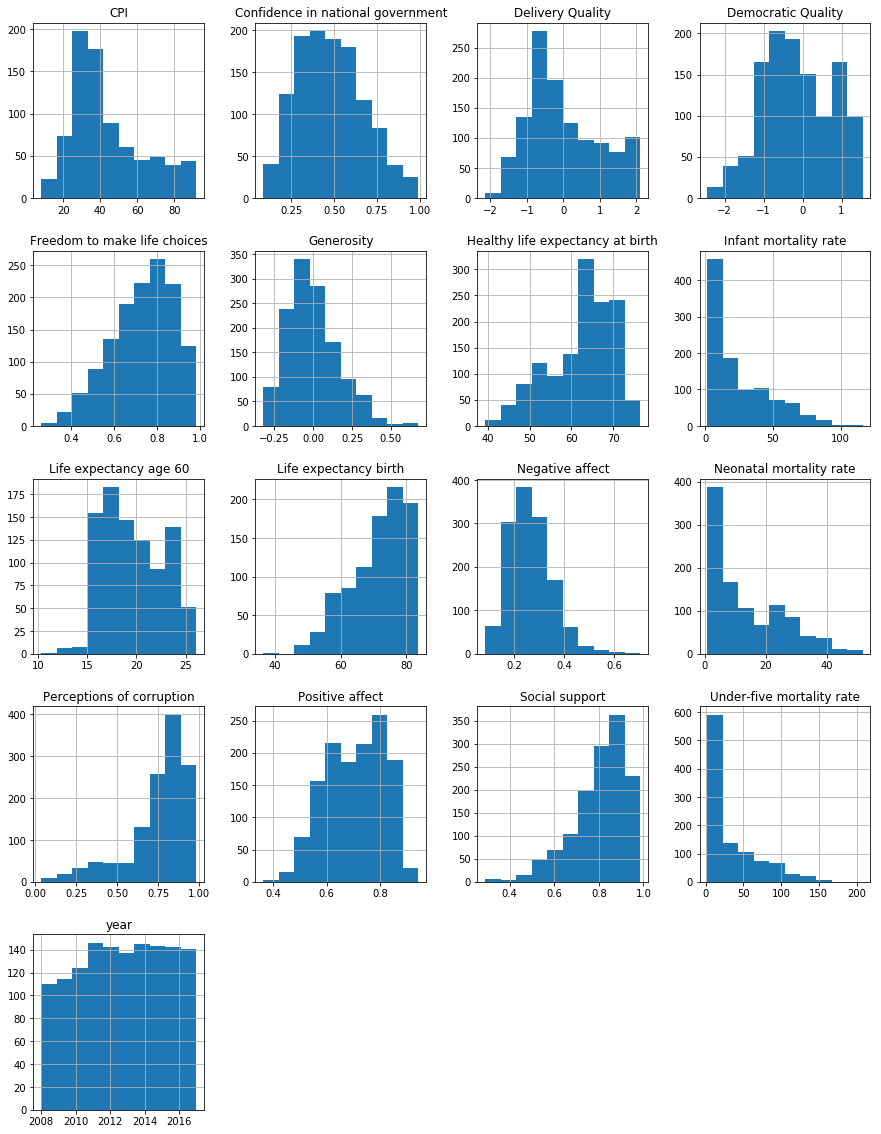

In [30]:
#Plot histogram for continous features
df.hist(figsize=(15,20))

#Show the plot and then proceed to clear the current figure to reuse for other plots
plt.show()
plt.clf()

#### Categorical Data

In [31]:
#Get descriptive stats for continous data
cat_feat = df.describe(include=["category"]).T

#rename some coulmns for improved understanding
cat_feat.rename(index=str, columns={"unique":"card", "top":"mode", "freq":"modeFreq"}, inplace=True)

#Create a DF containing only categorical data
cat_df = df.select_dtypes(include=["category"])
cat_df.index = df.index

#Add percentage missing by checking for missing data in each column. 
#NOTE: This only considers NA values as missing. Data could still be absent
#      but replaced with a "dummy" entry such as a blank space or a zero.
#      This issue Will be adressed in the Data Quality plan.
missing = cat_df.isnull().apply(pd.Series.sum)
print("Missing count for each categorical feature:\n")
print(missing)
cat_feat["missPerc"] = missing/1000 * 100

Missing count for each categorical feature:

country            0
Happiness Score    0
dtype: int64


In [32]:
#Add mode percentage 
cat_feat["modePerc"] = cat_feat.modeFreq/1000 * 100

#Add 2n mode category, frequency and percentage
#First get the 2n mode value for each column and its count
sec_mode = []
sec_mode_count = []
for col in cat_df:
    cat_df[col].cat.categories
    sec_mode.append(cat_df[col].value_counts().index[1])
    sec_mode_count.append(cat_df[col].value_counts().iloc[1])

#Add to df
cat_feat["secMode"] = sec_mode
cat_feat["secModeFreq"] = sec_mode_count
cat_feat["secModePerc"] = cat_feat.secModeFreq/1000 * 100

#Prettify the result, rearrange columns etc.
cat_feat = cat_feat[["count", "missPerc", "card", "mode", "modeFreq", "modePerc", "secMode", "secModeFreq", "secModePerc" ]]
print("Descriptive statistics for categorical features:")
display(cat_feat)

Descriptive statistics for categorical features:


,count,missPerc,card,mode,modeFreq,modePerc,secMode,secModeFreq,secModePerc
country,1344,0.0,162,Zimbabwe,10,1,Kosovo,10,1.0
Happiness Score,1344,0.0,6,5,435,43.5,6,342,34.2


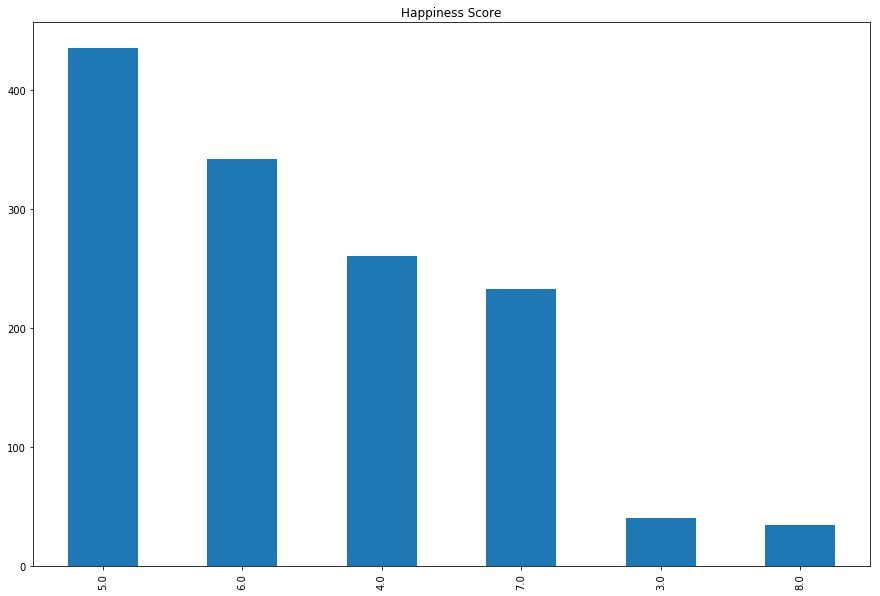

In [33]:
#plot happiness
fig = cat_df["Happiness Score"].value_counts().plot(kind="bar", title=col, figsize=(15, 10))
plt.show()
    
#Close pdf and clear figure
plt.clf()

### Part C - Data Quality Plan
The categorical data seems fine. We have no missing values in any row and the cardinality seems appropriate for both features. There seems to be more work for the continous data as we have a substantial amount of missing data. Before that though a quick look at the other issues. GDP seemed to have a very low minimum and very high maximum. So I investigate it next.

In [34]:
df.dtypes

country                              category
year                                    int64
Happiness Score                      category
Social support                        float64
Healthy life expectancy at birth      float64
Freedom to make life choices          float64
Generosity                            float64
Perceptions of corruption             float64
Positive affect                       float64
Negative affect                       float64
Confidence in national government     float64
Democratic Quality                    float64
Delivery Quality                      float64
GDP                                    object
Life expectancy birth                 float64
Life expectancy age 60                float64
Infant mortality rate                 float64
Neonatal mortality rate               float64
Under-five mortality rate             float64
CPI                                   float64
dtype: object

In [35]:
# Min GDP Country
df[df.GDP == min(df.GDP)]

TypeError: '<' not supported between instances of 'float' and 'str'

In [36]:
# Max GDP country
df[df.GDP == max(df.GDP)]

TypeError: '>' not supported between instances of 'float' and 'str'

The values for GDP seem to be fine after seeing that the lowest one belongs to a very small country and the highest one to USA. Next I will investigate any missing data. There are several columns for which only a tiny fraction is missing such as Social support shown below. So for these cases I just replace each missing value with the countries average value for that column

In [37]:
df[df["Social support"].isnull()]

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate,CPI
20,Algeria,2010,5.0,NaN,64.298981,0.592696,-0.232023,0.618038,NaN,NaN,NaN,-1.140853,-0.740093,161.207,74.7,21.4,23.5,16.8,27.3,NaN
92,Bahrain,2014,6.0,NaN,65.764687,NaN,NaN,NaN,NaN,NaN,NaN,-1.109269,0.491516,33.388,76.8,19.6,6.7,3.1,7.8,49.0
378,Djibouti,2010,5.0,NaN,51.460163,0.763730,-0.067456,0.596910,NaN,NaN,0.692278,-0.506095,-0.683048,1.099,61.3,17.3,62.5,37.1,76.5,NaN
744,Kuwait,2014,6.0,NaN,65.056374,NaN,NaN,NaN,NaN,NaN,NaN,-0.254227,-0.127896,162.695,74.6,17.8,7.8,4.8,9.1,44.0
941,Morocco,2010,4.0,NaN,63.526836,0.662900,-0.174080,0.900453,NaN,NaN,NaN,-0.540801,-0.140432,93.217,72.8,18.8,28.8,21.4,33.5,NaN
1043,Oman,2011,7.0,NaN,66.183914,0.916293,-0.015441,NaN,NaN,0.295164,NaN,-0.314025,0.295601,67.937,75.8,20.3,9.9,5.5,11.5,NaN
1137,Qatar,2010,7.0,NaN,66.829788,NaN,0.060170,NaN,NaN,NaN,NaN,0.070845,0.925530,125.122,77.3,20.6,7.7,4.6,9.0,NaN
1140,Qatar,2015,6.0,NaN,67.537521,NaN,NaN,NaN,NaN,NaN,NaN,-0.074040,0.823927,164.641,78.2,21.3,7.4,4.2,8.6,71.0
1396,Tunisia,2009,5.0,NaN,64.893021,0.781496,-0.133612,0.722211,NaN,NaN,NaN,-0.648282,0.071959,43.624,74.7,19.4,15.7,11.0,18.3,NaN
1455,United Arab Emirates,2014,7.0,NaN,68.171936,NaN,NaN,NaN,NaN,NaN,NaN,-0.146230,1.070845,403.198,76.9,20.0,6.8,4.1,7.9,70.0


In [38]:
# Define a helper function which gets the average for a selected country's column values
def get_average(Country, col):
    '''Gets the average of a country's column values
    '''
    average = df[df.country==Country][col].mean()
    return average

In [39]:
# Replace the missing values for "Social support", "Healthy life expectancy at birth", "Freedom to make life choices", "Generosity", "Perceptions of corruption", "Positive affect", "Negative affect", "Confidence in national government", "Democratic Quality", "Delivery Quality", "GDP"
for col in ["Social support", "Healthy life expectancy at birth", "Freedom to make life choices", "Generosity", "Perceptions of corruption", "Positive affect", "Negative affect", "Confidence in national government", "Democratic Quality", "Delivery Quality", "GDP"]:
    Countries = df[df[col].isnull()].country
    Years =  df[df[col].isnull()].year
    for Country, Year in zip(Countries, Years):
        df.at[(df.country==Country) & (df.year==Year), col] =  get_average(Country, col)

Unfortunately this does not work for all of the selected columns. Some countires have no value at all for a certain feature, so naturally there is no average value that can be used to replace the missing value. One could replace the missing value by the worldwide average which is what I will do

In [40]:
for col in ["Healthy life expectancy at birth", "Generosity", "Perceptions of corruption", "Confidence in national government", "Democratic Quality", "Delivery Quality", "GDP"]:
    Countries = df[df[col].isnull()].country
    Years =  df[df[col].isnull()].year
    for Country, Year in zip(Countries, Years):
        df.at[(df.country==Country) & (df.year==Year), col] =  df[col].mean()

TypeError: must be str, not int

There are however a couple of features for which more data is missing, although there is an observanle trend to the amount that is missing. This depends on the dataset where the features came from. Data from the WHO has 33% missing, Infant mortality has 23% missing and CPI has 41% missing. Looking for trends in the missing data:

In [41]:
df[df["Life expectancy birth"].isnull()].year.value_counts()

2016    142
2017    141
2012     22
2011     21
2015     20
2014     20
2013     20
2010     17
2009     17
2008     17
Name: year, dtype: int64

In [42]:
df[df["Life expectancy age 60"].isnull()].year.value_counts()

2016    142
2017    141
2012     22
2011     21
2015     20
2014     20
2013     20
2010     17
2009     17
2008     17
Name: year, dtype: int64

In [43]:
# same for the other two values that came with the infant mortality data set
df[df["Infant mortality rate"].isnull()].year.value_counts()

2017    141
2012     22
2011     21
2016     20
2015     20
2014     20
2013     20
2010     17
2009     17
2008     17
Name: year, dtype: int64

In [44]:
df[df["CPI"].isnull()].year.value_counts()

2011    146
2010    124
2009    114
2008    110
2014     10
2016      9
2012      9
2017      8
2015      8
2013      8
Name: year, dtype: int64

Data seems to be missing mostly for the years 2016 and 2017. This makes sense as these are very recent and therefore not much was published on it. However since it is under 30% for all except CPI, I replace it with the countrys average, and if that does not exist then with the worldwide average. Hover CPI will be dropped as we do not have enough data considering it only ranges back to 2012. This is unfortunate, and if one wanted to include it in the dataset one would have to focus on only 2012-2017. Replacing five years worth of data with an average seems unrealistic to me. For one or two years I imagine that the average is a good approximation but for CPI there is just too much missing

In [45]:
# Replace the missing values for "Life expectancy birth", "Life expectancy age 60", "Infant mortality rate", "Neonatal mortality rate", "Under-five mortality rate"
for col in ["Life expectancy birth", "Life expectancy age 60", "Infant mortality rate", "Neonatal mortality rate", "Under-five mortality rate"]:
    Countries = df[df[col].isnull()].country
    Years =  df[df[col].isnull()].year
    for Country, Year in zip(Countries, Years):
        df.at[(df.country==Country) & (df.year==Year), col] =  get_average(Country, col)

In [46]:
# Replace by worldwide average evrything for which there was no national average
for col in ["Life expectancy birth", "Life expectancy age 60", "Infant mortality rate", "Neonatal mortality rate", "Under-five mortality rate"]:
    Countries = df[df[col].isnull()].country
    Years =  df[df[col].isnull()].year
    for Country, Year in zip(Countries, Years):
        df.at[(df.country==Country) & (df.year==Year), col] =  df[col].mean()

In [47]:
# drop CPI
df.drop(["CPI"], axis=1, inplace=True)

In [48]:
# write cleaned df to csv
df.to_csv("processed_data/cleaned_merged_happiness_data.csv", index=False)

## PART 3: Data Understanding
The last section in this notebook will be comitted to Data Understanding. This does not look for correlation between target and descriptive features but rather serves as an overview of the data and how it has developed over the past years. Maybe we will observe some interesting trends which can then be confirmed via the correlation steps in the next part.  

In [49]:
# Convert the target feature from categorical to numeric for plotting
df["Happiness Score"] = df["Happiness Score"].astype(int)
df.head()

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate
0,Afghanistan,2008,4,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2
1,Afghanistan,2009,4,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1
2,Afghanistan,2010,5,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7,65.7,48.0,90.2
3,Afghanistan,2011,4,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8,63.3,46.5,86.4
4,Afghanistan,2012,4,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8,61.0,45.1,82.8


One thing we thought was interesting was to see the development of each feature over the past 10 years. It would be interesting to see it for each country, however considering we have over 150 countries this would be far too much. So we looked at it in groupings, first worldwide and then divided up into Continents/Regions. 

One noteworthy thing we did for plotting is that we zoomed out quite far by setting the range of the y-axis as the lowest/heighest value that would make sense for that feature. We did that because we were more interested in the overall trend and less so in fluctuations. For example, the average of the worldwide Happiness Score when plotted naturally, shows  a lot of ups and downs, but this is really just in the range of -0.1 to +0.1 so not too significant. So really, it just did not change over the past 10 years, which is nicely seen when one zooms out to the natural limits for that feature (0 and 10).

DataError: No numeric types to aggregate

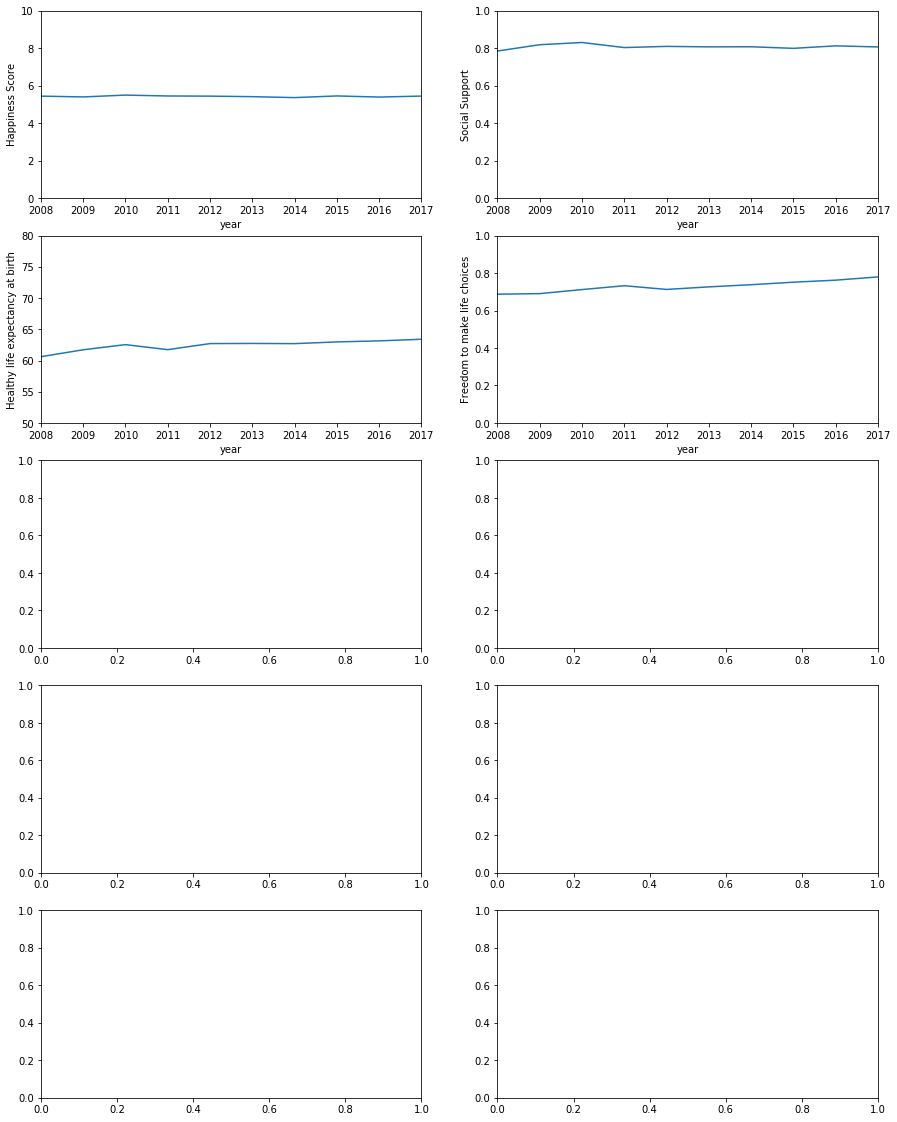

In [50]:
# plot the worldwide trends over the last 10 years for selected features
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))

df.groupby("year")["Happiness Score"].mean().plot(ax=axes[0,0])
axes[0, 0].set_ylim(0,10)
axes[0, 0].set_ylabel("Happiness Score")

df.groupby("year")["Social support"].mean().plot(ax=axes[0,1])
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_ylabel("Social Support")

df.groupby("year")["Healthy life expectancy at birth"].mean().plot(ax=axes[1,0])
axes[1, 0].set_ylim(50, 80)
axes[1, 0].set_ylabel("Healthy life expectancy at birth")

df.groupby("year")["Freedom to make life choices"].mean().plot(ax=axes[1,1])
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel("Freedom to make life choices")

df.groupby("year")["GDP"].mean().plot(ax=axes[2,0])
axes[2, 0].set_ylim(500, 600)
axes[2, 0].set_ylabel("GDP")

df.groupby("year")["Infant mortality rate"].mean().plot(ax=axes[2,1])
axes[2, 1].set_ylim(0, 35)
axes[2, 1].set_ylabel("Infant mortality rate")

df.groupby("year")["Positive affect"].mean().plot(ax=axes[3,0])
axes[3, 0].set_ylim(0, 1)
axes[3, 0].set_ylabel("Positive affect")

df.groupby("year")["Negative affect"].mean().plot(ax=axes[3,1])
axes[3, 1].set_ylim(0, 1)
axes[3, 1].set_ylabel("Negative affect")

df.groupby("year")["Democratic Quality"].mean().plot(ax=axes[4,0])
axes[4, 0].set_ylim(-2, 2)
axes[4, 0].set_ylabel("Democratic Quality")

df.groupby("year")["Confidence in national government"].mean().plot(ax=axes[4,1])
axes[4, 1].set_ylim(0, 1)
axes[4, 1].set_ylabel("Confidence in national government")

Observing the trends we cam make out some interesting developments. Many of the features, for the worldwide average, simply seemed to have stagnated. There does not seem to be an overall increase/decrease for features such as Democratic Quality, Positive affect or Happiness. However others showed a trend. Infant mortality rate has been steadily decreasing, so it will be interesting to see if that will correlate inversly with happiness score. In contrast, features such as "Healthy life expectancy at birth" and showed "Freedom to make life choices" showed a slight positive trend.

The reason why so many lines show little or no change is likely because we are looking at the worldwide average here. Surely, there must be regional differences so that is what we look at next.

In [51]:
# read in a dataset that contains a list of countrys annotated with their region
regions = pd.read_csv("raw_data/WHR151617.csv")
regions = regions[["Country", "Region"]]
regions.drop_duplicates(inplace=True)
regions.dropna(inplace=True)

In [52]:
# work on a copy of the original df to quickly restore it without having to rerun notebook
main_df = df

In [53]:
# Merge region data with original df giving each country a region
main_df = pd.merge(main_df, regions,  how='left', left_on=['country'], right_on = ["Country"])
main_df.drop("Country", axis=1, inplace=True)
main_df

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate,Region
0,Afghanistan,2008,4,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.100000,15.600000,70.800000,50.900000,98.200000,Southern Asia
1,Afghanistan,2009,4,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.600000,15.700000,68.200000,49.400000,94.100000,Southern Asia
2,Afghanistan,2010,5,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.800000,15.700000,65.700000,48.000000,90.200000,Southern Asia
3,Afghanistan,2011,4,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.200000,15.800000,63.300000,46.500000,86.400000,Southern Asia
4,Afghanistan,2012,4,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.500000,15.800000,61.000000,45.100000,82.800000,Southern Asia
5,Afghanistan,2013,4,0.483552,51.042980,0.577955,0.074735,0.823204,0.620585,0.273328,0.482847,-1.879709,-1.403036,20.17,59.900000,15.900000,58.800000,43.700000,79.300000,Southern Asia
6,Afghanistan,2014,3,0.525568,51.370525,0.508514,0.118579,0.871242,0.531691,0.374861,0.409048,-1.773257,-1.312503,20.616,59.900000,15.900000,56.800000,42.400000,76.100000,Southern Asia
7,Afghanistan,2015,4,0.528597,51.693527,0.388928,0.094686,0.880638,0.553553,0.339276,0.260557,-1.844364,-1.291594,20.079,60.500000,16.000000,54.900000,41.100000,73.200000,Southern Asia
8,Afghanistan,2016,4,0.559072,52.016529,0.522566,0.057072,0.793246,0.564953,0.348332,0.324990,-1.917693,-1.432548,19.454,59.312500,15.800000,53.200000,40.000000,70.400000,Southern Asia
9,Afghanistan,2017,3,0.490880,52.339527,0.427011,-0.106340,0.954393,0.496349,0.371326,0.261179,-1.904737,-1.485251,20.889,59.312500,15.800000,61.411111,45.233333,83.411111,Southern Asia


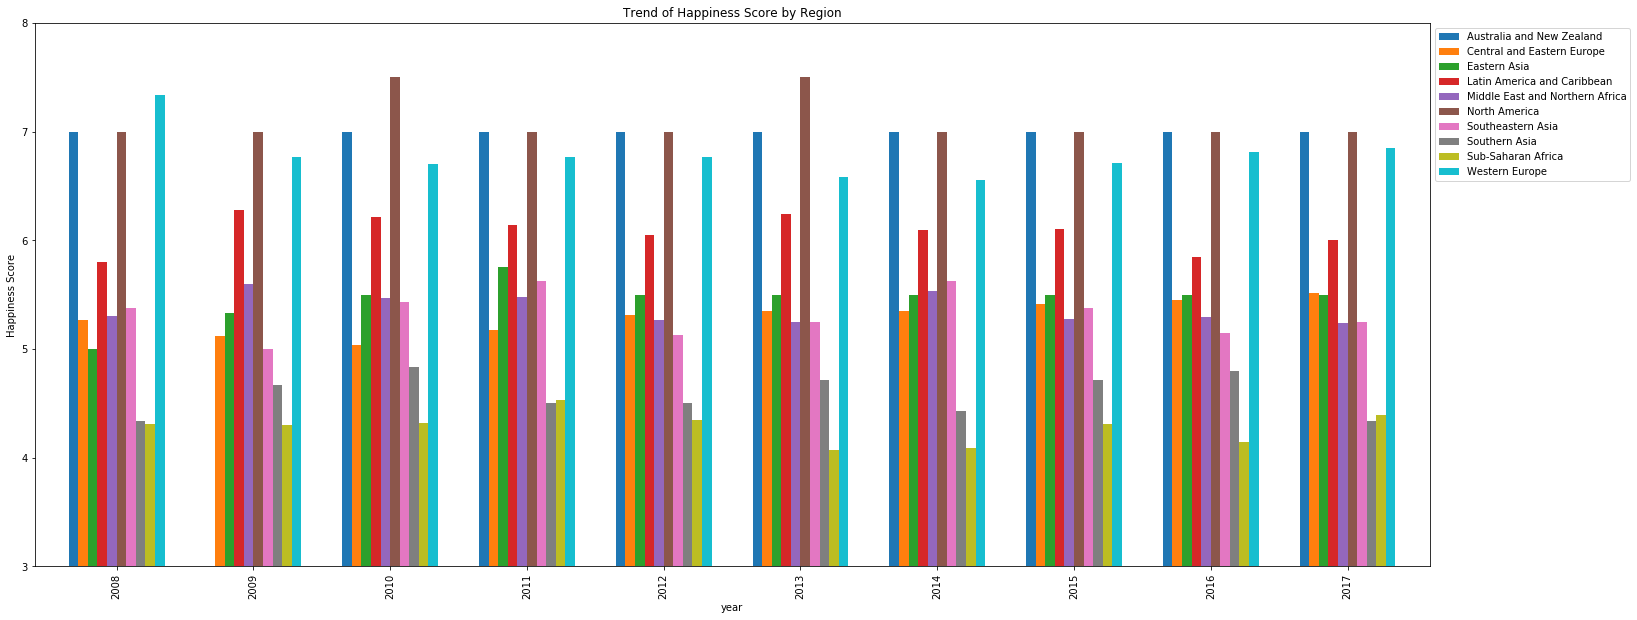

In [54]:
# plot the average happiness score by region over the past 10 years as a bar plot
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["Happiness Score"].mean().unstack(level=0).plot(kind="bar", ax=ax, width=0.7)
ax.set_ylim(3, 8)
ax.set_ylabel("Happiness Score")
ax.set_title("Trend of Happiness Score by Region")
ax.legend(bbox_to_anchor=(1,1))

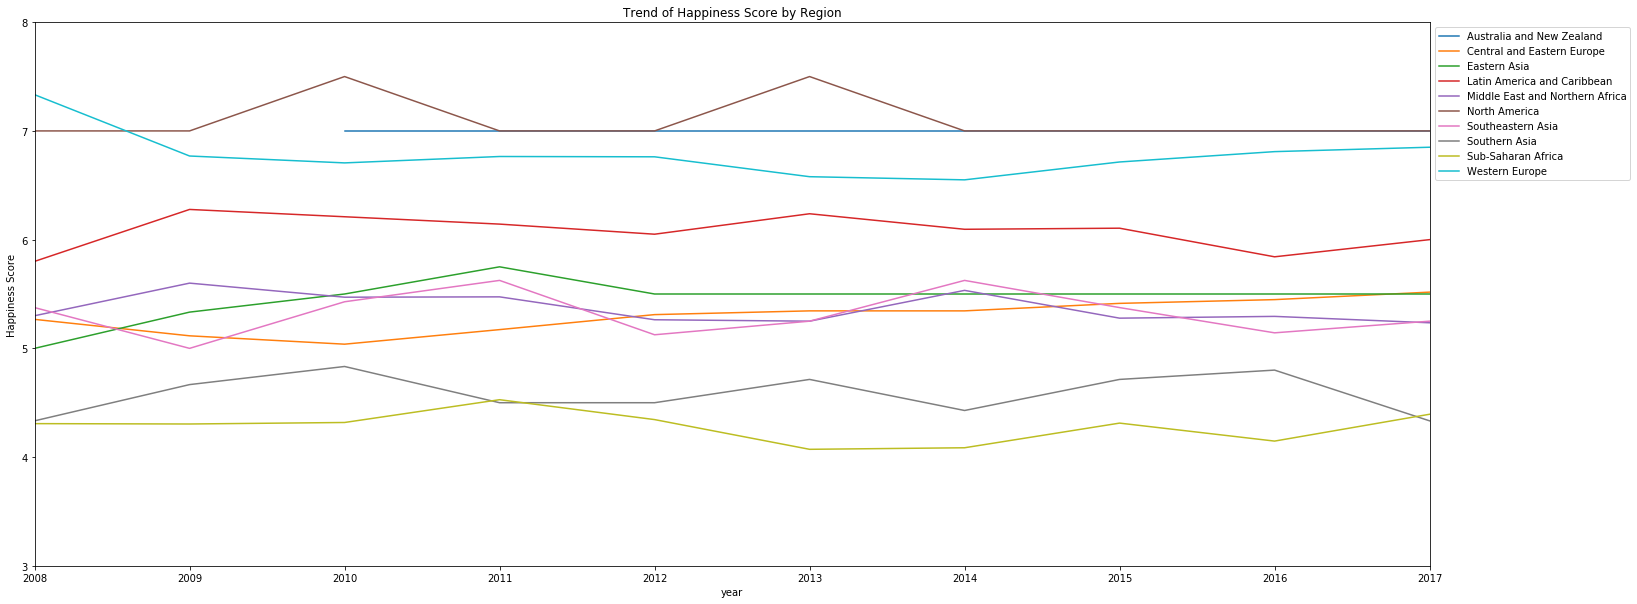

In [55]:
# plot the average happiness score by region over the past 10 years as a line plot
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["Happiness Score"].mean().unstack(level=0).plot(kind="line", ax=ax)
ax.set_ylim(3, 8)
ax.set_ylabel("Happiness Score")
ax.set_title("Trend of Happiness Score by Region")
ax.legend(bbox_to_anchor=(1,1))

Looking at the Happiness score as a line and bar plot by region allows one to see and compare the difference between regions as well as the overall trend. And although there is a bit of rearrangement between regions, with some "overtaking" others during the years there is no real difference between 2008 and 2017. Each regions score fluctuates a bit but often ends up at the same score, with some regions increasing it a bit and others dropping of. For example Australia and New Zealand stay consistently at 7. At this point it is worth noting that this does not mean there is no change at all. When we got the values as floats, we grouped them into bins according to the cantril ladder (0-10). So while the score for Australia and New Zealand could have maybe growing continously over the last 10 years (e.g. from 6.7-7) this trend is lost due to the bining.

Finally we show some of the more interesting descriptive values and their trends. This might not be directly important for feature selection, but it helps getting familiar with the data.

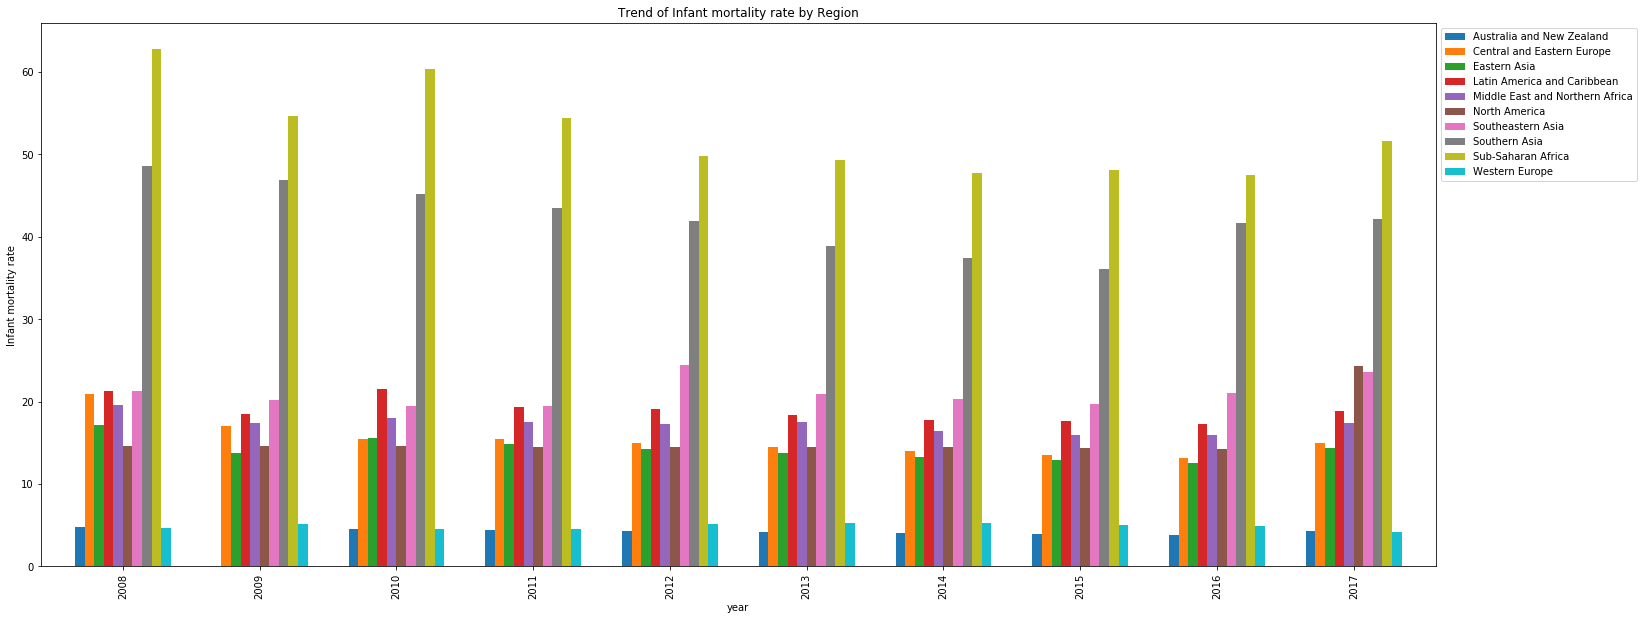

In [56]:
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["Infant mortality rate"].mean().unstack(level=0).plot(kind="bar", ax=ax, width=0.7)
#ax.set_ylim(3, 8)
ax.set_ylabel("Infant mortality rate")
ax.set_title("Trend of Infant mortality rate by Region")
ax.legend(bbox_to_anchor=(1,1))

DataError: No numeric types to aggregate

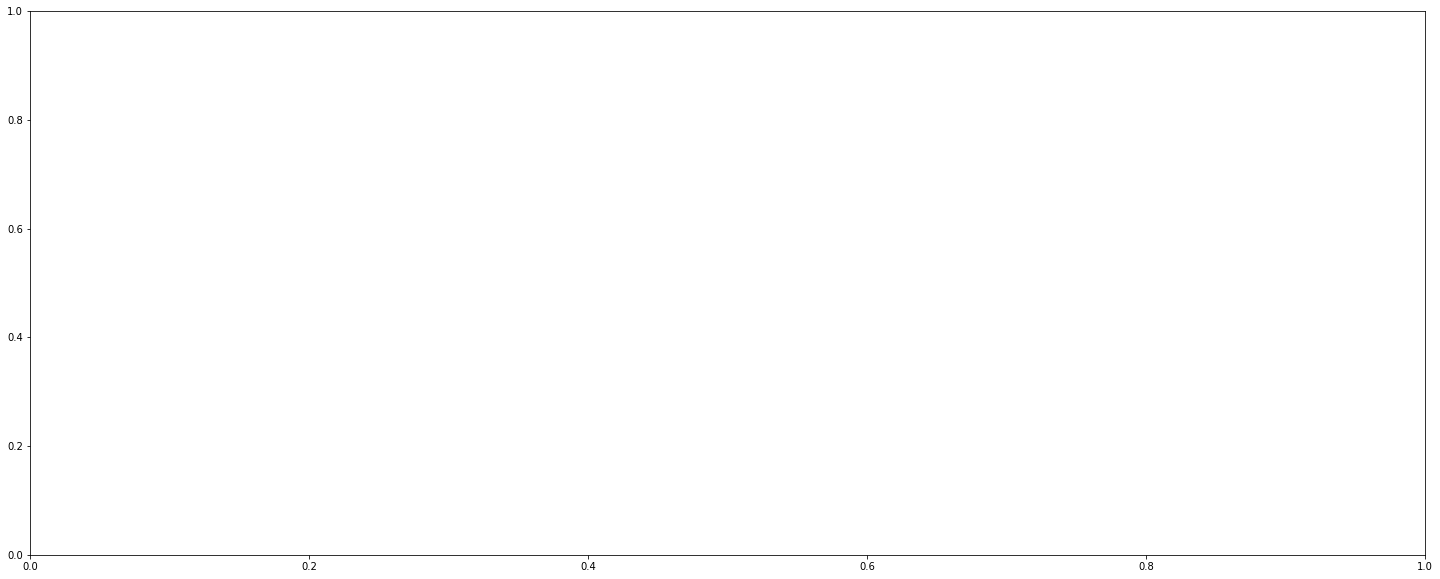

In [57]:
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["GDP"].mean().unstack(level=0).plot(kind="bar", ax=ax, width=0.7)
ax.set_ylabel("GDP")
ax.set_title("Trend of GDP by Region")
ax.legend(bbox_to_anchor=(1,1))

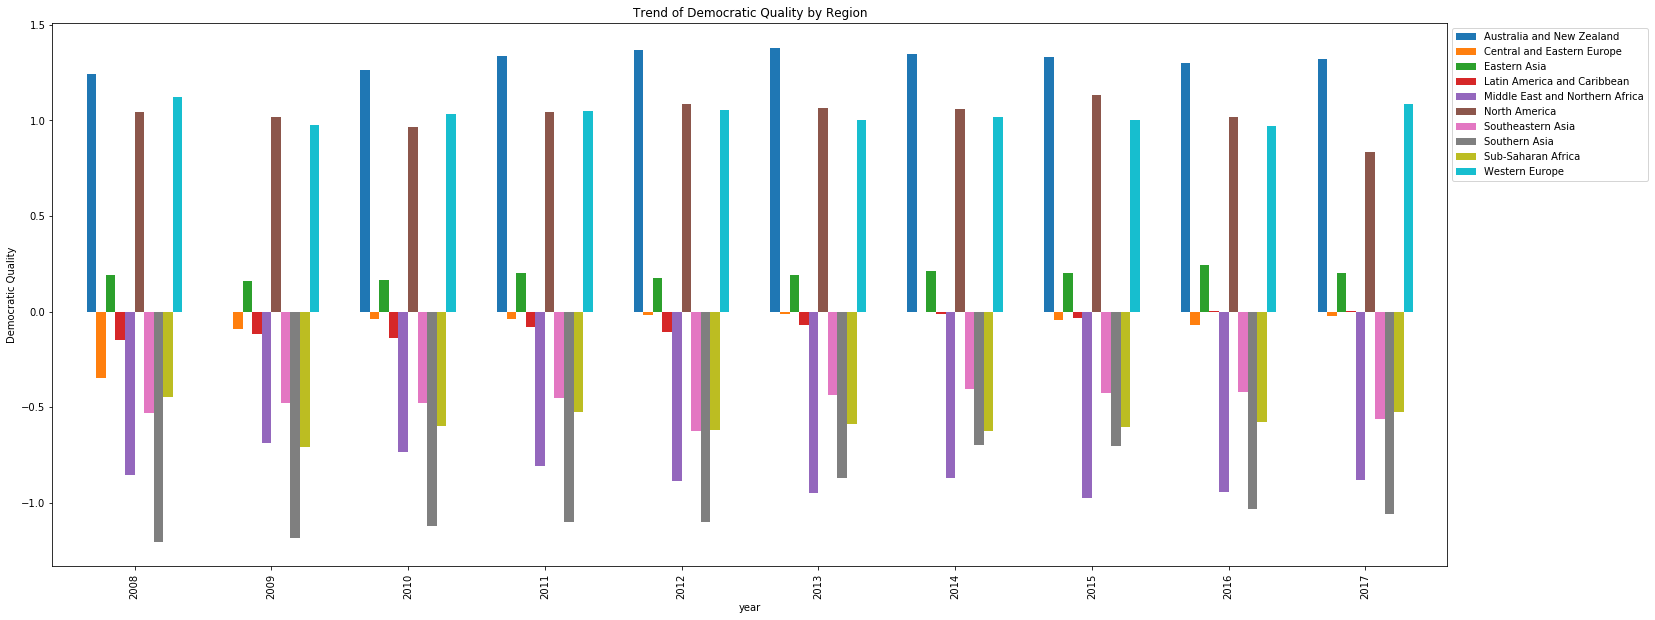

In [58]:
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["Democratic Quality"].mean().unstack(level=0).plot(kind="bar", ax=ax, width=0.7)
ax.set_ylabel("Democratic Quality")
ax.set_title("Trend of Democratic Quality by Region")
ax.legend(bbox_to_anchor=(1,1))

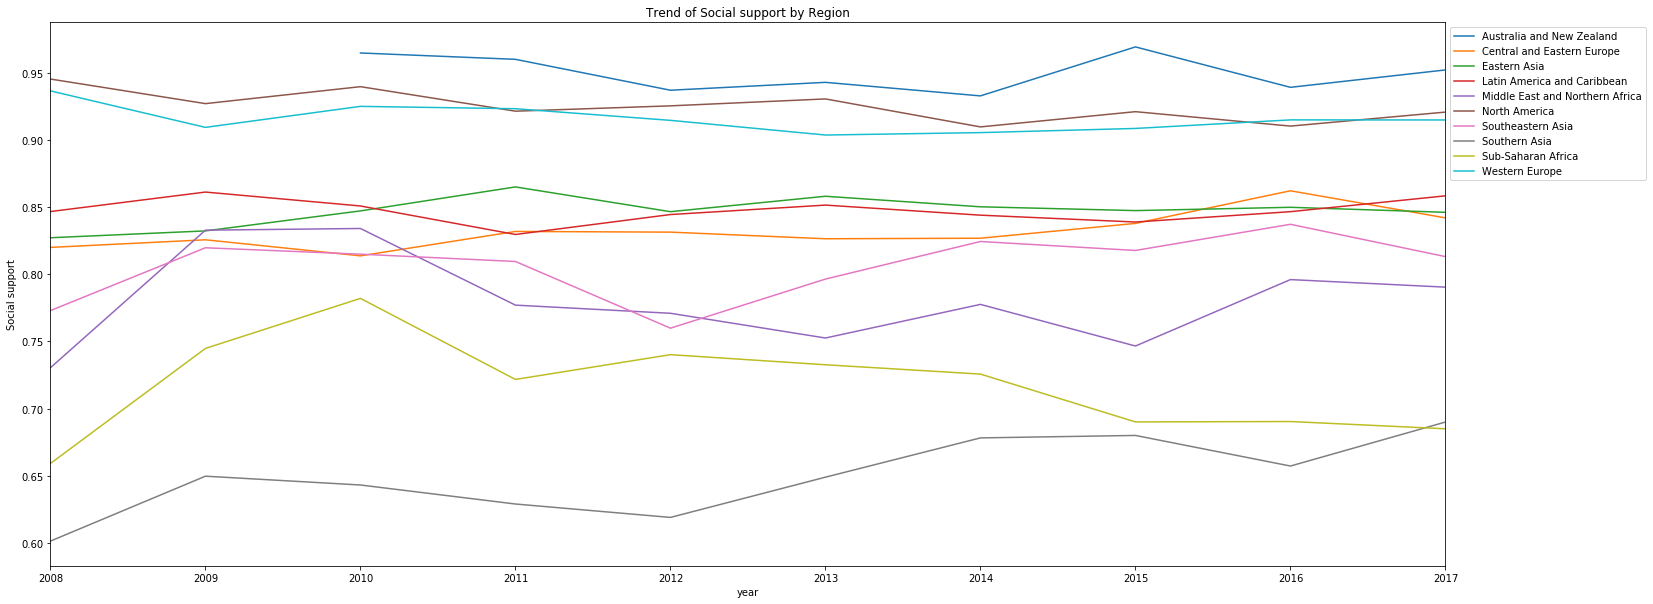

In [59]:
fig, ax = plt.subplots(figsize=(25,10))
main_df.groupby(["Region", "year"])["Social support"].mean().unstack(level=0).plot(kind="line", ax=ax)
ax.set_ylabel("Social support")
ax.set_title("Trend of Social support by Region")
ax.legend(bbox_to_anchor=(1,1))

In [60]:
# New DF - Numerical features:
continuous = df.select_dtypes(['int64', 'float64']).columns


In [61]:
# Randomize the data:
df = df.sample(frac=1).reset_index(drop=True)

In [62]:
# Create a training data set (first 70% of rows)
training_size = int(len(df) * 0.7)
df_train = df[:training_size]
print("Training set size (rows):",len(df_train))

Training set size (rows): 940


In [63]:
# Create a test data set (remaining 30% of rows)
training_size = int(len(df) * 0.7)
df_test = df[training_size:]
print("Test set:",len(df_test))

Test set: 404


In [64]:
# A copy of df for full cross validation purposes
df_cross = df

#### Correlations between all continuous features (Continuous vs continuous):

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text xticklabel objects>)

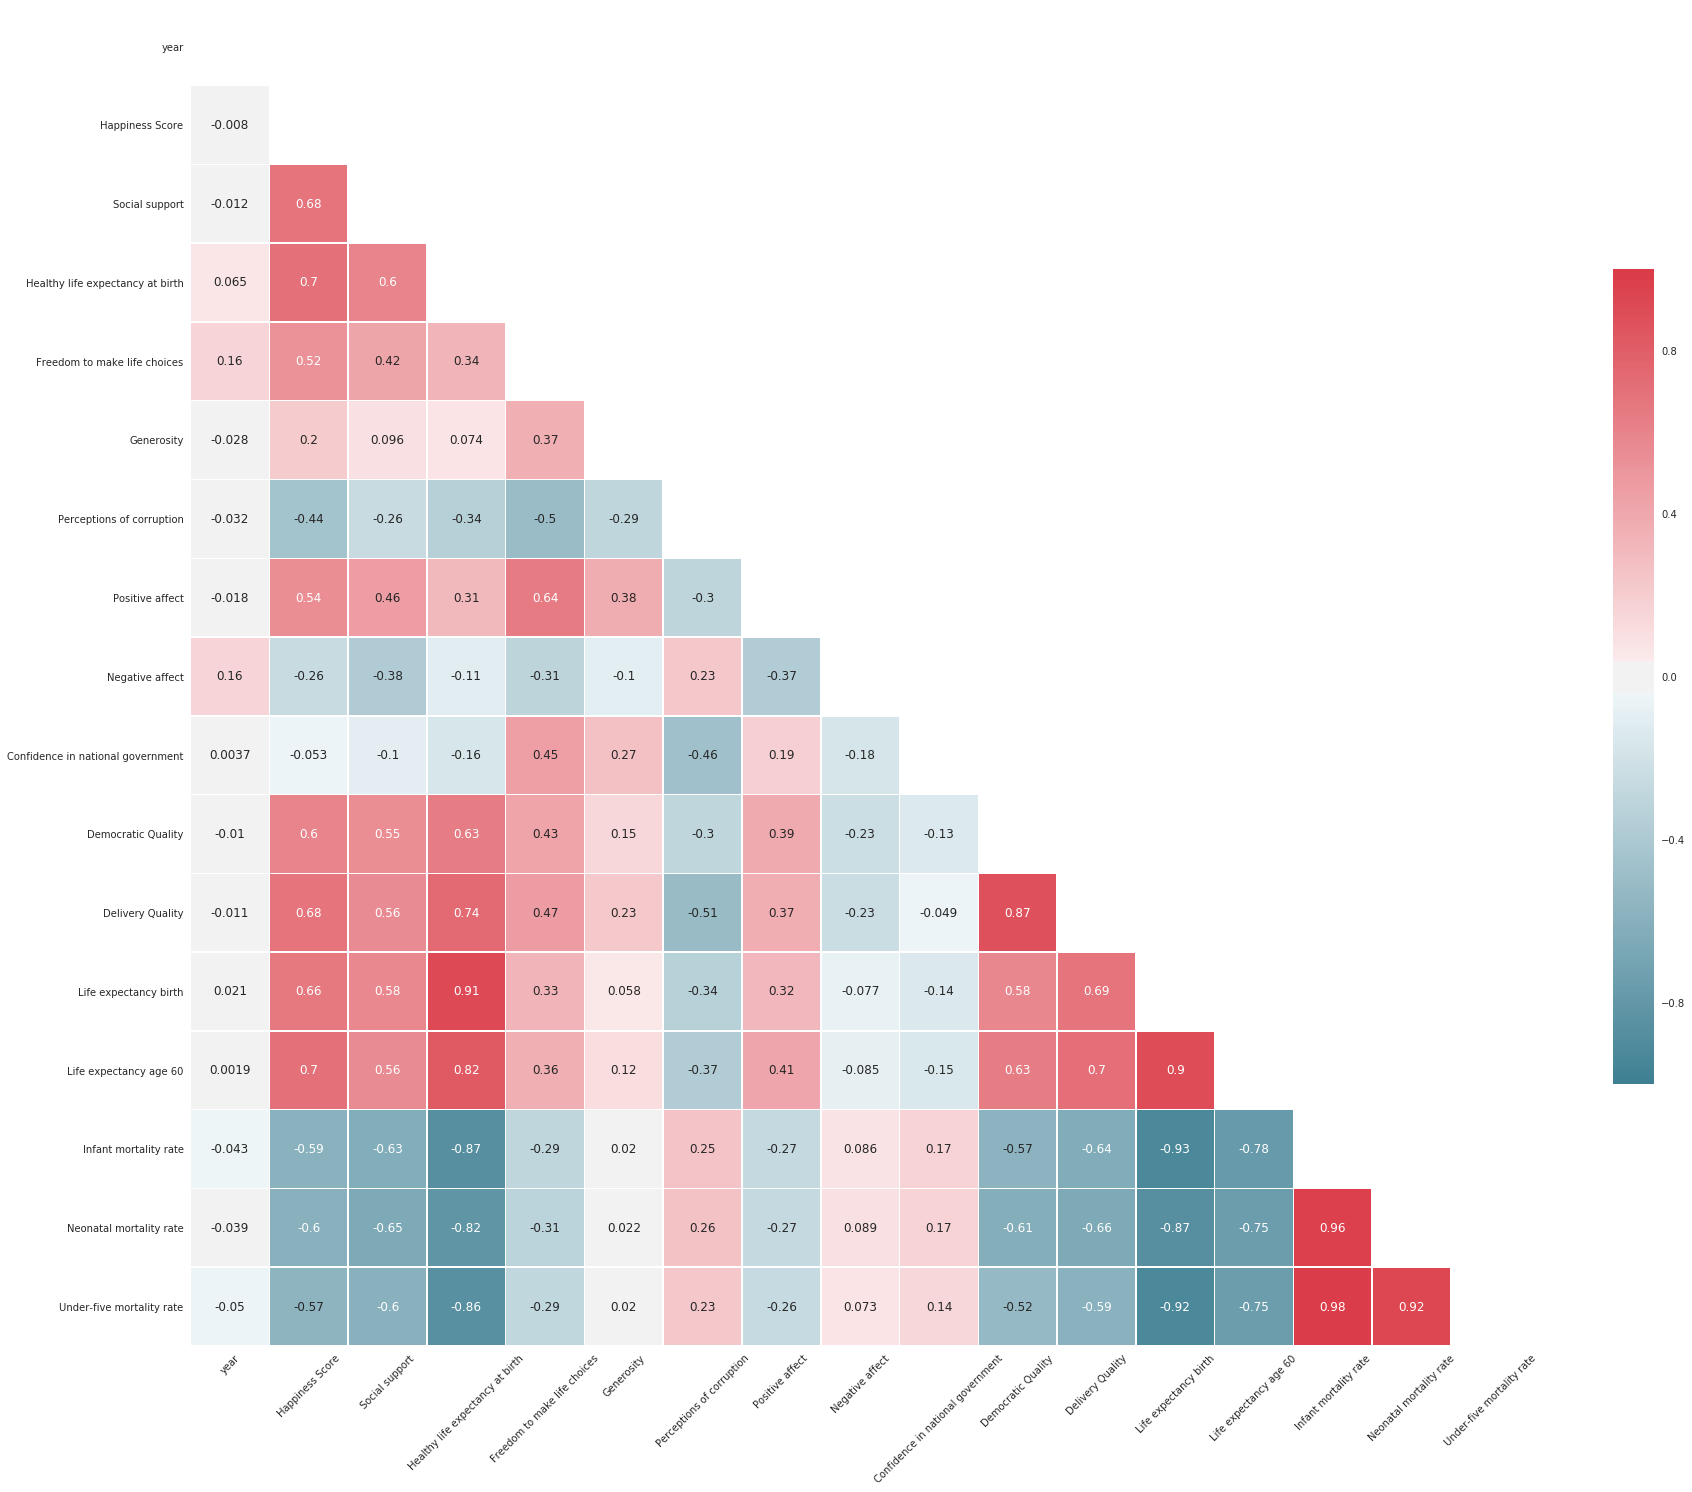

In [65]:
sns.set(style="white")
# Calculate correlation of all pairs of continuous features
corr = df_train[continuous].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

The heatmap above shows the correlation between all continuous features. This is useful for understanding which features affect other features. It is also useful for picking descriptive features to trian a model.

In the context of our dataset so far this means that all of our features are in the heatmap because all of our features are currently continuous.

The following features in df_train have a correlation of 80% or above:

- Delivery quality - Democratic quality
- Life expectancy age 60% - Life expectancy birth


- Neonatal mortality rate - Infant mortality rates
- Under-five mortality rate - Infant mortality rates


- Under-five mortality rate - Neonatal mortality rate


- Life expectancy at birth - Healthy life expectancy at birth
- Life expectancy at age 60 - Healthy life expectancy at birth

The following features in df_train have a correlation of -80% or below:
- Infant mortality rate - Healthy life expectancy at birth
- Neontal mortality rate - Healthy life expectancy at birth
- Under-five mortality rate - Healthy life expectancy at birth


- Infant mortality rate - Life expectancy at birth
- Neontal mortality rate - Life expectancy at birth
- Under-five mortality rate - Life expectancy at birth


Continuous vs categorical features:

Having looked at the heat map, we decided to further examine the correlations between the continuous features and the target feature. Having plotted the scatterplots and reflected upon which features we wanted to include as descriptive features in our model, we chose:
- Social support
- Healthy life expectancy at birth
- Democratic Quality, Delivery Quality
- Life expectancy age 60
- Infant mortality rate
- Positive affect

Their scatter plots are below:

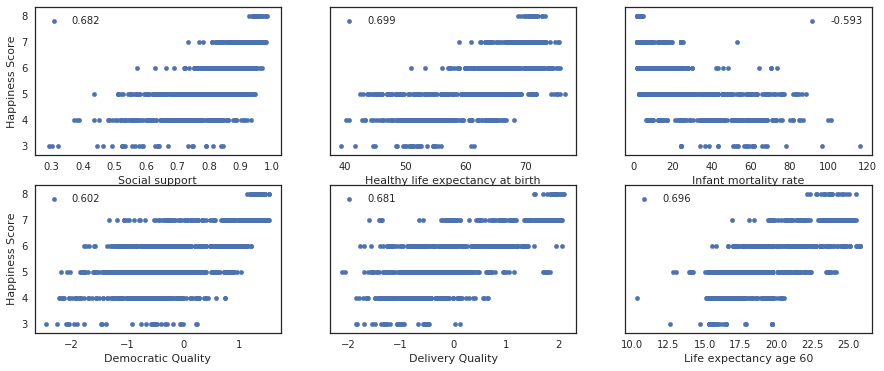

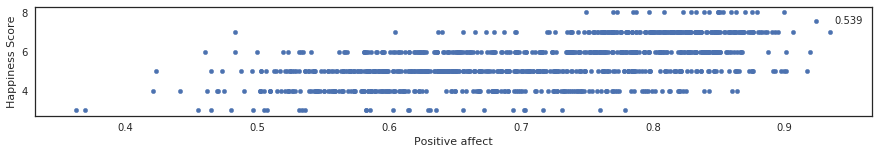

In [66]:
fig, axs = plt.subplots(2,3, sharey=True)

df_train.plot(kind='scatter', y='Happiness Score', x='Social support', label="%.3f" % df_train[['Social support', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,0], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Healthy life expectancy at birth', label="%.3f" % df_train[['Healthy life expectancy at birth', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,1], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Democratic Quality', label="%.3f" % df_train[['Democratic Quality', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,0], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Delivery Quality', label="%.3f" % df_train[['Delivery Quality', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,1], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Life expectancy age 60', label="%.3f" % df_train[['Life expectancy age 60', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,2], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Infant mortality rate', label="%.3f" % df_train[['Infant mortality rate', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,2], figsize=(15, 6))


df_train.plot(kind='scatter', y='Happiness Score', x='Positive affect', label="%.3f" % df_train[['Positive affect', 'Happiness Score']].corr().as_matrix()[0,1], figsize=(15, 2))

The correlation plots for the other continuous features are below:

IndexError: index 1 is out of bounds for axis 1 with size 1

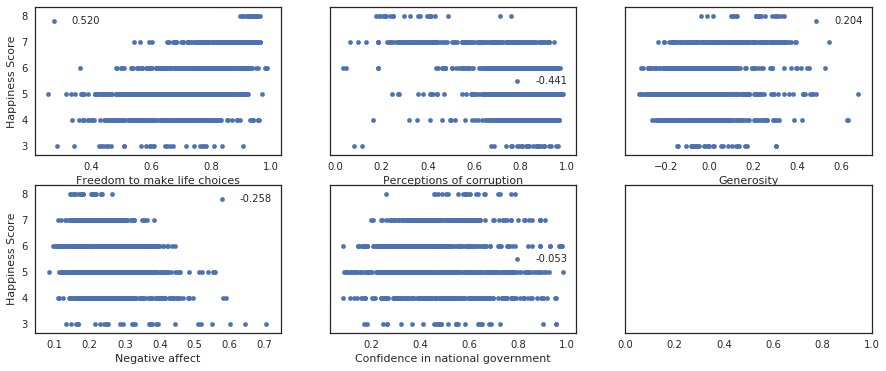

In [67]:
fig, axs = plt.subplots(2,3, sharey=True)

df_train.plot(kind='scatter', y='Happiness Score', x='Freedom to make life choices', label="%.3f" % df_train[['Freedom to make life choices', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,0], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Perceptions of corruption', label="%.3f" % df_train[['Perceptions of corruption', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,1], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Generosity', label="%.3f" % df_train[['Generosity', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[0,2], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Negative affect', label="%.3f" % df_train[['Negative affect', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,0], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='Confidence in national government', label="%.3f" % df_train[['Confidence in national government', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,1], figsize=(15, 6))
df_train.plot(kind='scatter', y='Happiness Score', x='GDP', label="%.3f" % df_train[['GDP', 'Happiness Score']].corr().as_matrix()[0,1], ax=axs[1,2], figsize=(15, 6))


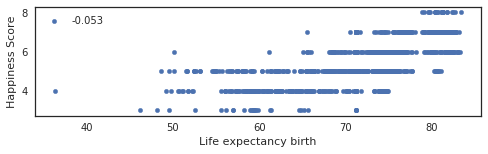

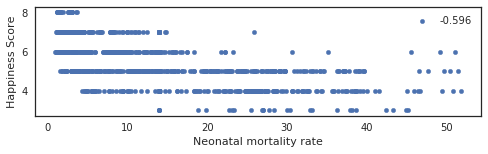

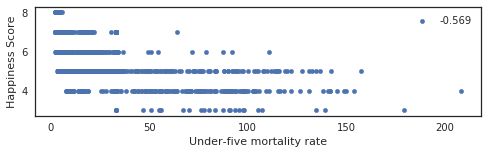

In [68]:
df_train.plot(kind='scatter', y='Happiness Score', x='Life expectancy birth', label="%.3f" % df_train[['Confidence in national government', 'Happiness Score']].corr().as_matrix()[0,1], figsize=(8, 2))
df_train.plot(kind='scatter', y='Happiness Score', x='Neonatal mortality rate', label="%.3f" % df_train[['Neonatal mortality rate', 'Happiness Score']].corr().as_matrix()[0,1], figsize=(8, 2))
df_train.plot(kind='scatter', y='Happiness Score', x='Under-five mortality rate', label="%.3f" % df_train[['Under-five mortality rate', 'Happiness Score']].corr().as_matrix()[0,1], figsize=(8, 2))

# Linear Regression

We will not train a linear regression model on the data set to produce a set of weights, one for each feature. Those weights will then be applied to the actual values plus an intercept to predict the Happiness Score.

formula: target_feature = w0 + w1 ∗ feature1 + w2 ∗ feature2 + ... + wn ∗ featuren

### Read data from CSV file.

The cleaned data from ealier has been saved to a csv file which I will now use.

In [69]:
df = pd.read_csv('processed_data/cleaned_merged_happiness_data.csv')

df.head(2)

,country,year,Happiness Score,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,GDP,Life expectancy birth,Life expectancy age 60,Infant mortality rate,Neonatal mortality rate,Under-five mortality rate
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1


### Changed column headers to remove spaces/capital letters and abbreviate descriptions

I have decided to make some changes to the column headers to make them easier to work with. All changes can be viewed below:  
country = country  
year = year  
happiness_score = Happiness Score  
social_support = Social support  
healthy_life_exp_birth = Healthy life expectancy at birth  
life_choices = Freedom to make life choices  
generosity = Generosity  
corruption = Perceptions of corruption  
pos_effect = Positive affect  
neg_affect = Negative affect  
confidence_gov = Confidence in national government  
dem_quality = Demoncratic Quality  
gdp = GDP  
life_exp_birth = Life expectancy birth  
life_exp_60 = Life expectancy age 60  
infant_mortality = Infant mortality rate  
neonatal_mortality = Neonatal mortality rate  
u5_mortaility = Under-five mortality rate  

In [70]:
df.columns = ["country", "year", "happiness_score", "social_support", "healthy_life_exp_birth", "life_choices", "generosity", "corruption", "pos_affect", "neg_affect", "confidence_gov", "dem_quality", "delivery_quality", "gdp", "life_exp_birth", "life_exp_60", "infant_mortality", "neonatal_mortality", "u5_mortality"]

### Transform happiness_score to a binary class & insert as happiness_class

We were initially going to predict a happiness_score between 0-10 but later decided to predict a binary result with a threshold of 5. I have applied the threshold to the happiness_score to create a new column called happiness_class. A happiness_scores of 5 and above becomes 1, with happiness_scores of less than 5 becoming 0.


In [71]:
happiness_class = (df['happiness_score']>5)*1.0
df_happiness_class = pd.DataFrame({'happiness_class':happiness_class})
df = pd.concat([df, df_happiness_class], axis=1)

In [72]:
df.head(5)

,country,year,happiness_score,social_support,healthy_life_exp_birth,life_choices,generosity,corruption,pos_affect,neg_affect,confidence_gov,dem_quality,delivery_quality,gdp,life_exp_birth,life_exp_60,infant_mortality,neonatal_mortality,u5_mortality,happiness_class
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,58.1,15.6,70.8,50.9,98.2,0.0
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,58.6,15.7,68.2,49.4,94.1,0.0
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,58.8,15.7,65.7,48.0,90.2,0.0
3,Afghanistan,2011,4.0,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,17.89,59.2,15.8,63.3,46.5,86.4,0.0
4,Afghanistan,2012,4.0,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,20.293,59.5,15.8,61.0,45.1,82.8,0.0


In [73]:
# mean target feature score
df.happiness_class.mean()

0.453125

In [74]:
df.dtypes

country                    object
year                        int64
happiness_score           float64
social_support            float64
healthy_life_exp_birth    float64
life_choices              float64
generosity                float64
corruption                float64
pos_affect                float64
neg_affect                float64
confidence_gov            float64
dem_quality               float64
delivery_quality          float64
gdp                        object
life_exp_birth            float64
life_exp_60               float64
infant_mortality          float64
neonatal_mortality        float64
u5_mortality              float64
happiness_class           float64
dtype: object

In [75]:
# check correlation for feature selection
df[[ "happiness_class", "country", "year", "social_support", "healthy_life_exp_birth", "life_choices", "generosity", "corruption", "pos_affect", "neg_affect", "confidence_gov", "dem_quality", "delivery_quality", "gdp", "life_exp_birth", "life_exp_60", "infant_mortality", "neonatal_mortality", "u5_mortality"]].corr()

,happiness_class,year,social_support,healthy_life_exp_birth,life_choices,generosity,corruption,pos_affect,neg_affect,confidence_gov,dem_quality,delivery_quality,life_exp_birth,life_exp_60,infant_mortality,neonatal_mortality,u5_mortality
happiness_class,1.000000,0.054499,0.601155,0.610530,0.449123,0.128654,-0.315596,0.485218,-0.206525,-0.124023,0.509799,0.559981,0.585935,0.631818,-0.530871,-0.546274,-0.507856
year,0.054499,1.000000,-0.001686,0.085714,0.181780,-0.003323,-0.052797,0.003580,0.192507,-0.002864,0.019568,0.005982,0.045016,0.040693,-0.066540,-0.061648,-0.068502
social_support,0.601155,-0.001686,1.000000,0.589475,0.415969,0.084150,-0.222379,0.456244,-0.365476,-0.149647,0.541915,0.549914,0.570871,0.559523,-0.605337,-0.629924,-0.579524
healthy_life_exp_birth,0.610530,0.085714,0.589475,1.000000,0.335576,0.054289,-0.314577,0.302134,-0.120397,-0.199992,0.621891,0.736790,0.918687,0.827421,-0.875910,-0.834034,-0.866297
life_choices,0.449123,0.181780,0.415969,0.335576,1.000000,0.351494,-0.495258,0.623822,-0.290106,0.418441,0.419629,0.458270,0.328524,0.367235,-0.290917,-0.307664,-0.285404
generosity,0.128654,-0.003323,0.084150,0.054289,0.351494,1.000000,-0.291499,0.366240,-0.097922,0.276602,0.115362,0.196835,0.030423,0.086943,0.040542,0.043253,0.038230
corruption,-0.315596,-0.052797,-0.222379,-0.314577,-0.495258,-0.291499,1.000000,-0.294326,0.248384,-0.449852,-0.285157,-0.498382,-0.307606,-0.348312,0.222328,0.230193,0.205088
pos_affect,0.485218,0.003580,0.456244,0.302134,0.623822,0.366240,-0.294326,1.000000,-0.385255,0.161131,0.378571,0.366900,0.304713,0.400902,-0.261728,-0.255344,-0.255688
neg_affect,-0.206525,0.192507,-0.365476,-0.120397,-0.290106,-0.097922,0.248384,-0.385255,1.000000,-0.167158,-0.238025,-0.249651,-0.085052,-0.093485,0.086652,0.082621,0.074034
confidence_gov,-0.124023,-0.002864,-0.149647,-0.199992,0.418441,0.276602,-0.449852,0.161131,-0.167158,1.000000,-0.165711,-0.074368,-0.187935,-0.192838,0.215414,0.218006,0.184351


### Remove a single feature from feature pairs with over 90% correlation

I have decided to remove feature pairs with over 90% correlation,  they are essentially telling us the same thing. The feature from the pair with the lowest level of negative/positive correlation with the target feature will be dropped. See the list of dropped features below:  

Feature correlation: 0.93 life_exp_birth vs healthy_life_exp_birth - drop life_exp_birth  
Feature correlation: 0.99 u5_mortality vs infant_mortality - drop u5_mortality  
Feature correlation: 0.96 neonatal_mortality vs infant_mortality - drop neonatal_mortality  
Feature correlation -0.92 u5_mortality vs life_exp_birth: both features dropped already due to correlation with other descriptive features.


In [76]:
df.drop('life_exp_birth', axis=1, inplace=True)

In [77]:
df.drop('u5_mortality', axis=1, inplace=True)

In [78]:
df.drop('neonatal_mortality', axis=1, inplace=True)

In [79]:
df.head(3)

,country,year,happiness_score,social_support,healthy_life_exp_birth,life_choices,generosity,corruption,pos_affect,neg_affect,confidence_gov,dem_quality,delivery_quality,gdp,life_exp_60,infant_mortality,happiness_class
0,Afghanistan,2008,4.0,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,10.297,15.6,70.8,0.0
1,Afghanistan,2009,4.0,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,12.066,15.7,68.2,0.0
2,Afghanistan,2010,5.0,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,15.325,15.7,65.7,0.0


### Feature Selection

I have decided to select features with a positive/negative correlation of greater than 0.50 away from 0. This threshold is an arbitrary one that we can change at a later stage if unhappy with the results it yields.  

##### Selected Features:  
social_support (target corr: 0.677275)  
healthy_life_exp_birth (target corr: 0.693580)  
pos_affect (target corr: 0.532431)  
dem_quality (target corr: 0.594980)  
delivery_quality (target corr: 0.670657)  
life_exp_60 (target corr: 0.698286)  
infant_mortality (target corr: -0.595494  

In [80]:
# selected feature correlation
df[["happiness_class", "social_support", "healthy_life_exp_birth", "pos_affect", "dem_quality", "delivery_quality", "life_exp_60", "infant_mortality"]].corr()

,happiness_class,social_support,healthy_life_exp_birth,pos_affect,dem_quality,delivery_quality,life_exp_60,infant_mortality
happiness_class,1.000000,0.601155,0.610530,0.485218,0.509799,0.559981,0.631818,-0.530871
social_support,0.601155,1.000000,0.589475,0.456244,0.541915,0.549914,0.559523,-0.605337
healthy_life_exp_birth,0.610530,0.589475,1.000000,0.302134,0.621891,0.736790,0.827421,-0.875910
pos_affect,0.485218,0.456244,0.302134,1.000000,0.378571,0.366900,0.400902,-0.261728
dem_quality,0.509799,0.541915,0.621891,0.378571,1.000000,0.866750,0.635915,-0.559324
delivery_quality,0.559981,0.549914,0.736790,0.366900,0.866750,1.000000,0.710327,-0.641283
life_exp_60,0.631818,0.559523,0.827421,0.400902,0.635915,0.710327,1.000000,-0.784651
infant_mortality,-0.530871,-0.605337,-0.875910,-0.261728,-0.559324,-0.641283,-0.784651,1.000000


### Training the model

This section trains the model on a linear relationship between descriptive features and the target feature. The data set is split 70/30 into a training set and test set. The purpose of this is to fit the model to the training set and then test that model on the testing set. This process helps avoid over/under fitting a model by using 100% of the data during fitting.


In [81]:
# Create a training data set (first 70% of rows)
training_size = int(len(df) * 0.7)
df_train = df[:training_size]
print("Training set size (rows):",len(df_train))

Training set size (rows): 940


In [82]:
# Create a test data set (remaining 30% of rows)
training_size = int(len(df) * 0.7)
df_test = df[training_size:]
print("Test set:",len(df_test))

Test set: 404


In [83]:
# A copy of df for full cross validation purposes
df_cross = df

In [84]:
# train model on all continuous features using df_train
lm = sm.ols(formula="happiness_class ~ social_support + healthy_life_exp_birth + pos_affect + dem_quality + delivery_quality + life_exp_60 + infant_mortality", data=df_train).fit()
print(lm.params)

Intercept                -2.632553
social_support            1.119994
healthy_life_exp_birth    0.003332
pos_affect                0.862037
dem_quality              -0.004743
delivery_quality          0.027721
life_exp_60               0.066706
infant_mortality          0.001483
dtype: float64


### Table with feature weights

The model has been trained on the df_train data set. A table helps us understand how some of the features performed.

In [85]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_class   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     165.4
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          1.44e-158
Time:                        15:50:12   Log-Likelihood:                -294.28
No. Observations:                 939   AIC:                             604.6
Df Residuals:                     931   BIC:                             643.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

### Test the model on df_train

Note: we also evaluate the model on the df_test to avoid overfitting

In [86]:
predictions = lm.predict(df_train)

In [87]:
happiness_prediction_classification = []
for i in predictions:
  if (i < 0.5):
      happiness_prediction_classification.append(0.0)
  else:
      happiness_prediction_classification.append(1.0)

In [88]:
happiness_prediction_classification

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0

### Actual Happiness Score vs Predicted Happiness

In [89]:
predict_df_train = pd.DataFrame({'ActualHappiness': df_train.happiness_class, 'PredictedHappiness': happiness_prediction_classification})
predict_df_train.head(10)

,ActualHappiness,PredictedHappiness
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


### Perform evaluation metrics on the model

I have applied some evaluation metrics to produce results on accuracy, the confusion matrics and the classification report. I will apply the same evaluation metrics to the test data below so we can analyse the difference. 

In [90]:
# Some evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(df_train['happiness_class'], happiness_prediction_classification))
print("Confusion matrix: \n", metrics.confusion_matrix(df_train['happiness_class'], happiness_prediction_classification))
print("Classification report:\n ", metrics.classification_report(df_train['happiness_class'], happiness_prediction_classification))

Accuracy:  0.852127659574
Confusion matrix: 
 [[477  53]
 [ 86 324]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.85      0.90      0.87       530
        1.0       0.86      0.79      0.82       410

avg / total       0.85      0.85      0.85       940



### Test on df_test

In [91]:
predictions = lm.predict(df_test)

In [92]:
happiness_prediction_classification = []
for i in predictions:
  if (i < 0.5):
      happiness_prediction_classification.append(0.0)
  else:
      happiness_prediction_classification.append(1.0)

In [93]:
predict_df_test = pd.DataFrame({'ActualHappiness': df_test.happiness_class, 'PredictedHappiness': happiness_prediction_classification})
predict_df_test.head(10)

,ActualHappiness,PredictedHappiness
940,1.0,1.0
941,1.0,1.0
942,1.0,1.0
943,1.0,1.0
944,1.0,1.0
945,1.0,1.0
946,1.0,1.0
947,1.0,1.0
948,1.0,1.0
949,0.0,0.0


### Perform evaluation metrics on df_test data set results

In [94]:
# more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(df_test['happiness_class'], happiness_prediction_classification))
print("Confusion matrix: \n", metrics.confusion_matrix(df_test['happiness_class'], happiness_prediction_classification))
print("Classification report:\n ", metrics.classification_report(df_test['happiness_class'], happiness_prediction_classification))

Accuracy:  0.841584158416
Confusion matrix: 
 [[185  20]
 [ 44 155]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.81      0.90      0.85       205
        1.0       0.89      0.78      0.83       199

avg / total       0.85      0.84      0.84       404



### Perfrom normalisation of the features

This process will give each feature a relative value and help to compare the coef of different features.

In [95]:
df_feat = df_train[['happiness_class', 'social_support', 'healthy_life_exp_birth', 'pos_affect', 'dem_quality', 'delivery_quality', 'life_exp_60', 'infant_mortality']]

In [96]:
df_feat.min()

happiness_class            0.000000
social_support             0.290184
healthy_life_exp_birth    40.076595
pos_affect                 0.422928
dem_quality               -2.044093
delivery_quality          -1.900852
life_exp_60               10.300000
infant_mortality           1.600000
dtype: float64

In [97]:
df_feat.max()

happiness_class             1.000000
social_support              0.987343
healthy_life_exp_birth     76.536362
pos_affect                  0.943621
dem_quality                 1.540097
delivery_quality            2.121312
life_exp_60                26.100000
infant_mortality          101.300000
dtype: float64

In [98]:
# range normalise all columns
df_norm = (df_feat - df_feat.min()) / (df_feat.max() - df_feat.min())
df_norm.head(10)

,happiness_class,social_support,healthy_life_exp_birth,pos_affect,dem_quality,delivery_quality,life_exp_60,infant_mortality
0,0.0,0.230189,0.250497,0.181891,0.031919,0.061103,0.335443,0.694082
1,0.0,0.375989,0.261873,0.309199,0.000000,0.066091,0.341772,0.668004
2,0.0,0.357007,0.272420,0.375150,0.014587,0.070528,0.341772,0.642929
3,0.0,0.331229,0.282248,0.361940,0.034896,0.070766,0.348101,0.618857
4,0.0,0.330559,0.291627,0.552066,0.056107,0.123509,0.348101,0.595787
5,0.0,0.277365,0.300780,0.379604,0.045864,0.123768,0.354430,0.573721
6,0.0,0.337633,0.309764,0.208883,0.075564,0.146277,0.354430,0.553661
7,0.0,0.341978,0.318623,0.250869,0.055725,0.151475,0.360759,0.534604
8,0.0,0.385690,0.327482,0.272762,0.035266,0.116431,0.348101,0.517553
9,0.0,0.287877,0.336341,0.141006,0.038881,0.103328,0.348101,0.599911


### Train Linear Model on normalised columns

The values of each column have been normalised so we can now train a model on them and compare the coef with one another.

In [99]:
lm_df_norm = sm.ols(formula="happiness_class ~ social_support + healthy_life_exp_birth + pos_affect + dem_quality + delivery_quality + life_exp_60 + infant_mortality", data=df_norm).fit()
print(lm_df_norm.params)

Intercept                -1.162974
social_support            0.780815
healthy_life_exp_birth    0.121494
pos_affect                0.448857
dem_quality              -0.017000
delivery_quality          0.111498
life_exp_60               1.053960
infant_mortality          0.147845
dtype: float64


In [100]:
print(lm_df_norm.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_class   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     165.4
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          1.44e-158
Time:                        15:50:29   Log-Likelihood:                -294.28
No. Observations:                 939   AIC:                             604.6
Df Residuals:                     931   BIC:                             643.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

### Standardisation of features

In [101]:
df_st = (df_feat - df_feat.mean()) / df_feat.std()
df_st.head(10)

,happiness_class,social_support,healthy_life_exp_birth,pos_affect,dem_quality,delivery_quality,life_exp_60,infant_mortality
0,-0.879069,-2.808808,-1.707488,-1.749264,-2.125722,-1.703961,-1.445899,2.139915
1,-0.879069,-1.988406,-1.653840,-1.135243,-2.259258,-1.683236,-1.411412,2.020281
2,-0.879069,-2.095214,-1.604104,-0.817157,-2.198232,-1.664795,-1.411412,1.905248
3,-0.879069,-2.240266,-1.557756,-0.880868,-2.113266,-1.663808,-1.376926,1.794817
4,-0.879069,-2.244033,-1.513525,0.036133,-2.024529,-1.444625,-1.376926,1.688987
5,-0.879069,-2.543351,-1.470361,-0.795673,-2.067382,-1.443548,-1.342439,1.587758
6,-0.879069,-2.204229,-1.427995,-1.619081,-1.943127,-1.350011,-1.342439,1.495732
7,-0.879069,-2.179783,-1.386217,-1.416579,-2.026126,-1.328408,-1.307952,1.408307
8,-0.879069,-1.933818,-1.344439,-1.310987,-2.111720,-1.474039,-1.376926,1.330085
9,-0.879069,-2.484204,-1.302661,-1.946458,-2.096596,-1.528492,-1.376926,1.707903


In [102]:
lm_df_st = sm.ols(formula="happiness_class ~ social_support + healthy_life_exp_birth + pos_affect + dem_quality + delivery_quality + life_exp_60 + infant_mortality", data=df_st).fit()
print(lm_df_st.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_class   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     165.4
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          1.44e-158
Time:                        15:50:32   Log-Likelihood:                -952.36
No. Observations:                 939   AIC:                             1921.
Df Residuals:                     931   BIC:                             1959.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0